<a href="https://colab.research.google.com/github/andy-wqfang/EE488_IBED/blob/main/EE488_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Overview

In [ ]:
# All Includes

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Conv1D
from tensorflow.keras.utils import to_categorical
import os

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "acc.x",
    "acc.y",
    "acc.z",
    "gyro.x",
    "gyro.y",
    "gyro.z",
]

# Output classes to learn how to classify
LABELS = [
    "FULL_STRIKE",
    "LIFT",
    "CHOP",
    "BACKHAND_SAVE",

]



## Data processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import re
from collections import defaultdict


In [ ]:
dataset = defaultdict(list)
labels = defaultdict(list)

In [ ]:
def read_all_files_in_directory(directory_path,label):
    all_data_blocks = {}
    lens = []
    for filename in os.listdir(directory_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory_path, filename)
            pattern = r'(.*?)\.csv'
            # 使用正则表达式进行匹配
            data_blocks = read_csv_blocks(file_path)
            matchs = re.search(pattern, filename)
            dataset[matchs.group(1).upper()].extend(data_blocks)  # 将当前文件的所有数据块添加到总列表中
            labels[matchs.group(1).upper()].extend([label for x in range(0,len(data_blocks))])
    return lens

In [ ]:

def read_csv_blocks(file_path):
    # Read csv files
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data_blocks = []
    current_block = []

    for line in lines:
        if line.strip() == '':  # encounter blank line
            if current_block:
                data_blocks.append(current_block)
                current_block = []
        else:
            current_block.append(line.strip().split(','))  # 将行数据拆分并加入当前块

    # 添加最后一个块（如果存在）
    if current_block:
        data_blocks.append(current_block)

    # set up dataframes
    dataframes = []
    i=0
    for block in data_blocks:
        # 将每个块转换为DataFrame
        #df = pd.DataFrame(block[1:], columns=block[0])  # 跳过标题行
        if i  != 0:
          dataframes.append([b for a in block for b in a ])
        else:
          dataframes.append([b for a in block[1:] for b in a ])
        i+=1
    #dataframes is a list
    return dataframes

In [ ]:
DATA_PATH = ('/content/drive/MyDrive/EE488/')

l = 0
for label in LABELS:
  print("Loading pattern: "+ label)
  read_all_files_in_directory(DATA_PATH+label+'/',l)
  l += 1


Loading pattern: FULL_STRIKE
Loading pattern: LIFT
Loading pattern: CHOP
Loading pattern: BACKHAND_SAVE


In [ ]:
print(dataset.keys())#
print(labels.keys())

dict_keys(['USER1', 'USER2', 'USER3', 'USER4', 'USER5'])
dict_keys(['USER1', 'USER2', 'USER3', 'USER4', 'USER5'])


## Label one hot

In [ ]:
for user in ['USER2', 'USER4', 'USER3', 'USER1', 'USER5']:
  labels[user] = [[1 if i == value else 0 for i in range(4)] for value in labels[user]]
print(len(labels['USER1'][1]))

4


# Split the dataset

In [ ]:
#Spilit to 5 leave-one-user-out models and one general model

XLeaveUser1 = []
[XLeaveUser1.extend(value) for key, value in dataset.items() if key not in ('USER1')]
XLeaveUser2 = []
[XLeaveUser2.extend(value) for key, value in dataset.items() if key not in ('USER2')]
XLeaveUser3 = []
[XLeaveUser3.extend(value) for key, value in dataset.items() if key not in ('USER3')]
XLeaveUser4 = []
[XLeaveUser4.extend(value) for key, value in dataset.items() if key not in ('USER4')]
XLeaveUser5 = []
[XLeaveUser5.extend(value) for key, value in dataset.items() if key not in ('USER5')]
XGeneral =  []
[XGeneral.extend(value) for key, value in dataset.items()]
YLeaveUser1 = []
[YLeaveUser1.extend(value) for key, value in labels.items() if key not in ('USER1')]
YLeaveUser2 = []
[YLeaveUser2.extend(value) for key, value in labels.items() if key not in ('USER2')]
YLeaveUser3 = []
[YLeaveUser3.extend(value) for key, value in labels.items() if key not in ('USER3')]
YLeaveUser4 = []
[YLeaveUser4.extend(value) for key, value in labels.items() if key not in ('USER4')]
YLeaveUser5 = []
[YLeaveUser5.extend(value) for key, value in labels.items() if key not in ('USER5')]
YGeneral =  []
[YGeneral.extend(value) for key, value in labels.items()]


[None, None, None, None, None]

In [ ]:
print(len(XLeaveUser1))
print(len(XLeaveUser2))
print(len(XLeaveUser3))
print(len(XLeaveUser4))
print(len(XLeaveUser5))
print(len(XGeneral))

print(len(YLeaveUser1))
print(len(YLeaveUser2))
print(len(YLeaveUser3))
print(len(YLeaveUser4))
print(len(YLeaveUser5))
print(len(YGeneral))

607
638
578
608
641
768
607
638
578
608
641
768


Split Train and Test set function

In [ ]:
import random
# set the seed
random.seed(42)
TRAIN_PERCENT = 80
TEST_PERCENT = 100 - TRAIN_PERCENT


In [ ]:
def split_train_test(x,y,mname):
  #x dataset,y dataset,model name
  train_size = int(len(x) * float(TRAIN_PERCENT/100))
  test_size = len(x) - train_size
  train_indices = random.sample(range(len(x)), train_size)

  x_train = []
  y_train = []
  for i in train_indices:
    x_train.append(x[i])
    y_train.append(y[i])
  x_test = []
  y_test = []

  for i in list(set(list(range(0, len(x))))-set(train_indices)):
    x_test.append(x[i])
    y_test.append(y[i])
  print(mname+" Train size: " + str(len(x_train)) +" Test size: " + str(len(x_test)))

  fx_train = [[float(item) for item in sublist] for sublist in x_train]
  fx_test = [[float(item) for item in sublist] for sublist in x_test]
  x_train_ = np.array(fx_train)
  y_train_ = np.array(y_train)
  print(f"Data type of x_train: {x_train_.dtype}")
  print(f"Data type of y_train: {y_train_.dtype}")
  x_test_ = np.array(fx_test)
  y_test_ = np.array(y_test)

  print(f"x_train shape: {x_train_.shape}")  #
  print(f"y_train shape: {y_train_.shape}")

  x_train__ = x_train_.reshape((x_train_.shape[0], 1, x_train_.shape[1]))
  x_test__ = x_test_.reshape((x_test_.shape[0], 1, x_test_.shape[1]))

  print(f"x_test shape: {x_test__.shape}")
  print(f"y_test shape: {y_test_.shape}")
  return x_train__,y_train_,x_test__,y_test_

In [ ]:
x_train_1,y_train_1,x_test_1,y_test_1 = split_train_test(XLeaveUser1,YLeaveUser1,"Leave User 1")
x_train_2,y_train_2,x_test_2,y_test_2 = split_train_test(XLeaveUser2,YLeaveUser2,"Leave User 2")
x_train_3,y_train_3,x_test_3,y_test_3 = split_train_test(XLeaveUser3,YLeaveUser3,"Leave User 3")
x_train_4,y_train_4,x_test_4,y_test_4 = split_train_test(XLeaveUser4,YLeaveUser4,"Leave User 4")
x_train_5,y_train_5,x_test_5,y_test_5 = split_train_test(XLeaveUser5,YLeaveUser5,"Leave User 5")
x_train_g,y_train_g,x_test_g,y_test_g = split_train_test(XGeneral,YGeneral,"General Model")

Leave User 1 Train size: 485 Test size: 122
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (485, 120)
y_train shape: (485, 4)
x_test shape: (122, 1, 120)
y_test shape: (122, 4)
Leave User 2 Train size: 510 Test size: 128
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (510, 120)
y_train shape: (510, 4)
x_test shape: (128, 1, 120)
y_test shape: (128, 4)
Leave User 3 Train size: 462 Test size: 116
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (462, 120)
y_train shape: (462, 4)
x_test shape: (116, 1, 120)
y_test shape: (116, 4)
Leave User 4 Train size: 486 Test size: 122
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (486, 120)
y_train shape: (486, 4)
x_test shape: (122, 1, 120)
y_test shape: (122, 4)
Leave User 5 Train size: 512 Test size: 129
Data type of x_train: float64
Data type of y_train: int64
x_train shape: (512, 120)
y_train shape: (512, 4)
x_test shape: (129, 1, 120)
y_test s

# Model building and training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.LSTM(120, return_sequences=True)(inputs)
    x = layers.Dropout(0.4)(x)

    x = layers.LSTM(120)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, x)

# Define input shape and number of classes
input_shape = (1, 120)
num_classes = 4
# Create the model



In [ ]:
model_1 = make_model(input_shape, num_classes)
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_2 = make_model(input_shape, num_classes)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_3 = make_model(input_shape, num_classes)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4 = make_model(input_shape, num_classes)
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_5 = make_model(input_shape, num_classes)
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_g = make_model(input_shape, num_classes)
model_g.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_g.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 120)]          0         
                                                                 
 lstm_22 (LSTM)              (None, 1, 120)            115680    
                                                                 
 dropout_22 (Dropout)        (None, 1, 120)            0         
                                                                 
 lstm_23 (LSTM)              (None, 120)               115680    
                                                                 
 dropout_23 (Dropout)        (None, 120)               0         
                                                                 
 dense_22 (Dense)            (None, 120)               14520     
                                                                 
 dense_23 (Dense)            (None, 4)                 484

Train

In [ ]:

EPOCHS = 50
# Callback to save model checkpoints for future inspection or training
loss = []
accuracy = []


#model_1
print(f'model_1 begins to train....')
history_1 = model_1.fit(x_train_1, y_train_1, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_1, y_test_1))
lo, ac = model_1.evaluate(x_test_1, y_test_1)
loss.append(lo)
accuracy.append(ac)

#model_2

print(f'model_2) begins to train....')
history_2 = model_2.fit(x_train_2, y_train_2, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_2, y_test_2))
lo, ac = model_2.evaluate(x_test_2, y_test_2)
loss.append(lo)
accuracy.append(ac)
#model_3

print(f'model_3 begins to train....')
history_3 = model_3.fit(x_train_3, y_train_3, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_3, y_test_3))
lo, ac = model_3.evaluate(x_test_3, y_test_3)
loss.append(lo)
accuracy.append(ac)
#model_4

print(f'model_4 begins to train....')
history_4 = model_4.fit(x_train_4, y_train_4, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_4, y_test_4))
lo, ac = model_4.evaluate(x_test_4, y_test_4)
loss.append(lo)
accuracy.append(ac)
#model_5
print(f'model_5 begins to train....')
history_5 = model_5.fit(x_train_5, y_train_5, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_5, y_test_5))
lo, ac = model_5.evaluate(x_test_5, y_test_5)
loss.append(lo)
accuracy.append(ac)
#model_g
print(f'model_g begins to train....')
history_g = model_g.fit(x_train_g, y_train_g, epochs=EPOCHS,
          batch_size = 8,validation_data=(x_test_g, y_test_g))
lo, ac = model_g.evaluate(x_test_g, y_test_g)
loss.append(lo)
accuracy.append(ac)


model_1 begins to train....
Epoch 1/50
61/61 [==============================] - 7s 23ms/step - loss: 1.3721 - accuracy: 0.3443 - val_loss: 1.3404 - val_accuracy: 0.4344
Epoch 2/50
61/61 [==============================] - 0s 7ms/step - loss: 1.1808 - accuracy: 0.4907 - val_loss: 1.1662 - val_accuracy: 0.4098
Epoch 3/50
61/61 [==============================] - 0s 8ms/step - loss: 1.0002 - accuracy: 0.5464 - val_loss: 1.1418 - val_accuracy: 0.4836
Epoch 4/50
61/61 [==============================] - 0s 7ms/step - loss: 0.8876 - accuracy: 0.5835 - val_loss: 1.1519 - val_accuracy: 0.4836
Epoch 5/50
61/61 [==============================] - 0s 8ms/step - loss: 0.7656 - accuracy: 0.6680 - val_loss: 1.2357 - val_accuracy: 0.5000
Epoch 6/50
61/61 [==============================] - 0s 7ms/step - loss: 0.7098 - accuracy: 0.7052 - val_loss: 1.2152 - val_accuracy: 0.5328
Epoch 7/50
61/61 [==============================] - 0s 8ms/step - loss: 0.6141 - accuracy: 0.7361 - val_loss: 1.2428 - val_accuracy

## Plots

### Epoch loss and validation loss

In [ ]:
def plot_training(history,name):
  train_loss = history.history['loss']
  train_accuracy = history.history['accuracy']
  val_loss = history.history['val_loss']
  val_accuracy = history.history['val_accuracy']
  epochs = range(1, len(train_loss) + 1)

  # 绘制图表
  plt.figure(figsize=(10, 5))

  # 绘制损失曲线
  plt.plot(epochs, train_loss, 'b--', label='Training Loss')
  plt.plot(epochs, val_loss, 'r--', label='Validation Loss')

  # 绘制准确率曲线
  plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
  plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')

  plt.title(name+' training and validation metrics')
  plt.xlabel('Epochs')
  plt.grid(True)
  plt.legend()
  plt.show()



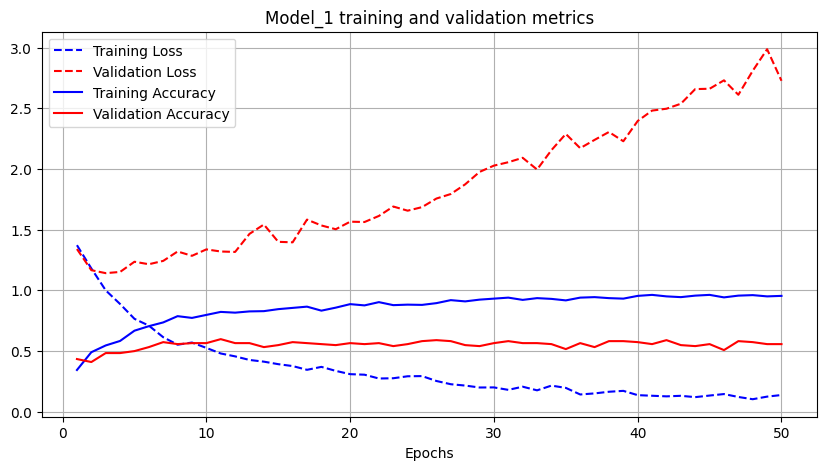

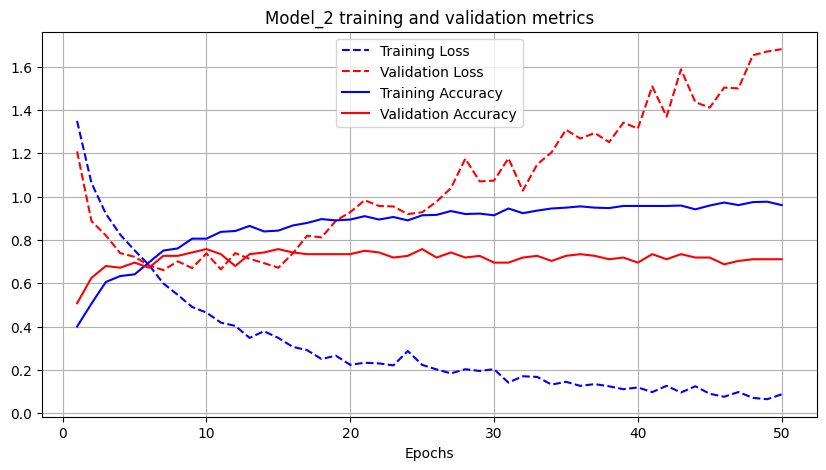

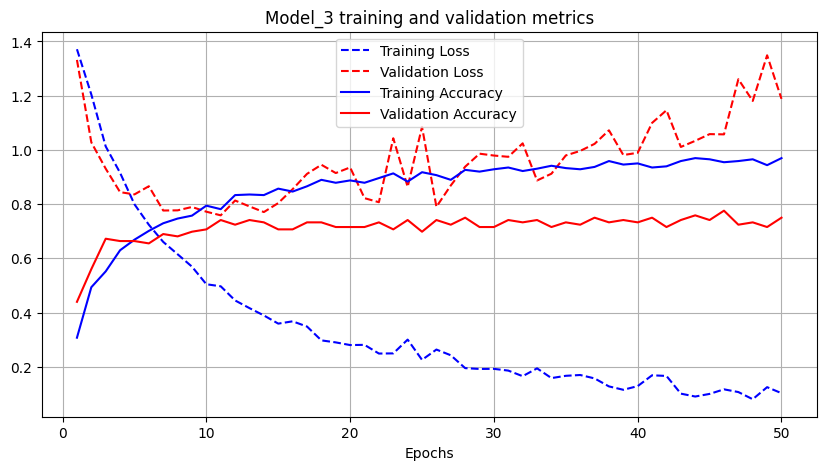

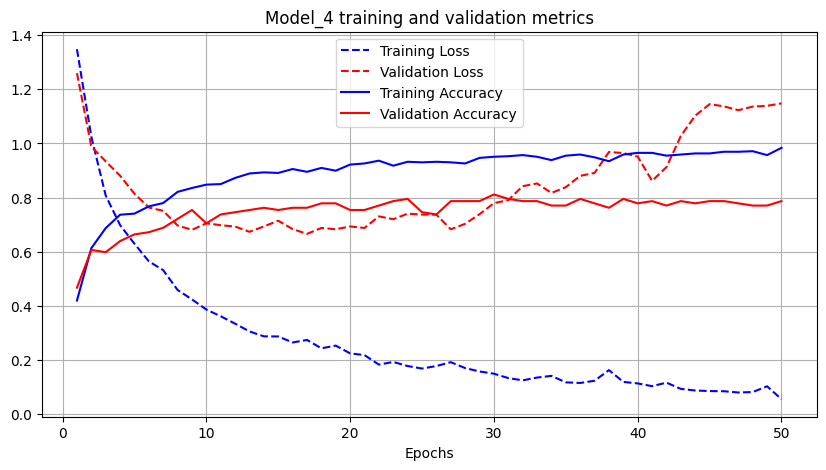

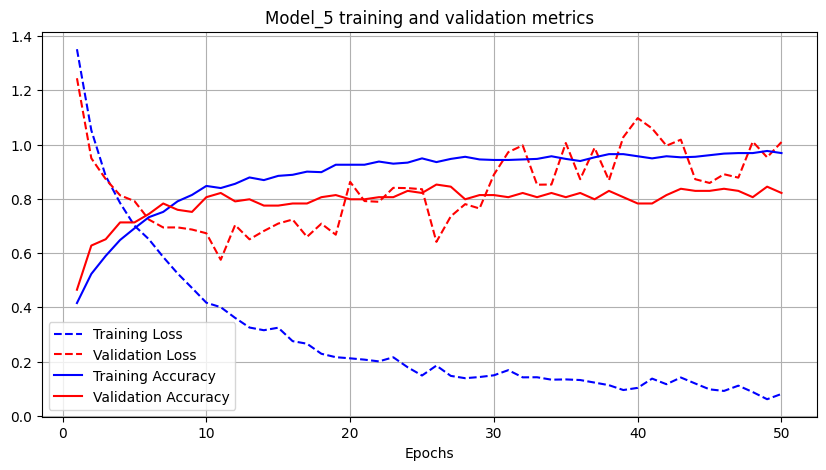

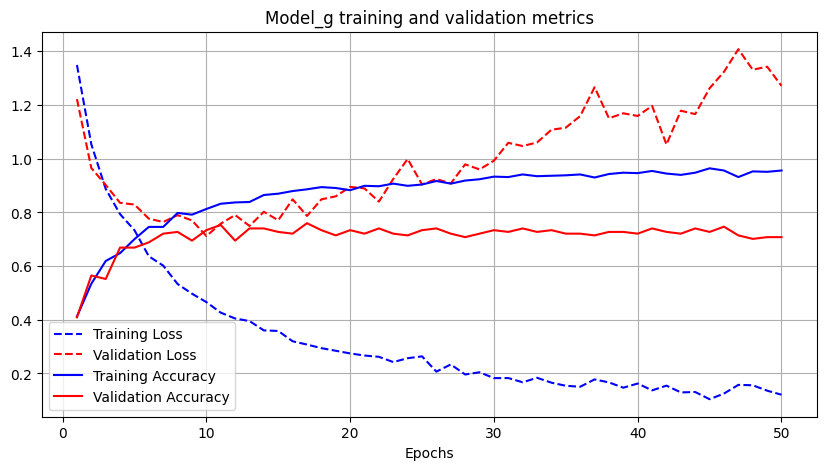

In [ ]:
plot_training(history_1,"Model_1")
plot_training(history_2,"Model_2")
plot_training(history_3,"Model_3")
plot_training(history_4,"Model_4")
plot_training(history_5,"Model_5")
plot_training(history_g,"Model_g")


### Plot test accuracy and loss

In [ ]:
def plot_test(loss,accuracy):
  plt.figure(figsize=(10, 5))

  plt.plot(['Model1','Model2','Model3','Model4','Model5','ModelG'], accuracy, 'r', label='Test accuracy')
  plt.plot(['Model1','Model2','Model3','Model4','Model5','ModelG'], loss, 'b', label='Test loss')
  plt.title('Test set performance')
  plt.xlabel('Models')
  plt.grid(True)
  plt.legend()
  plt.show()


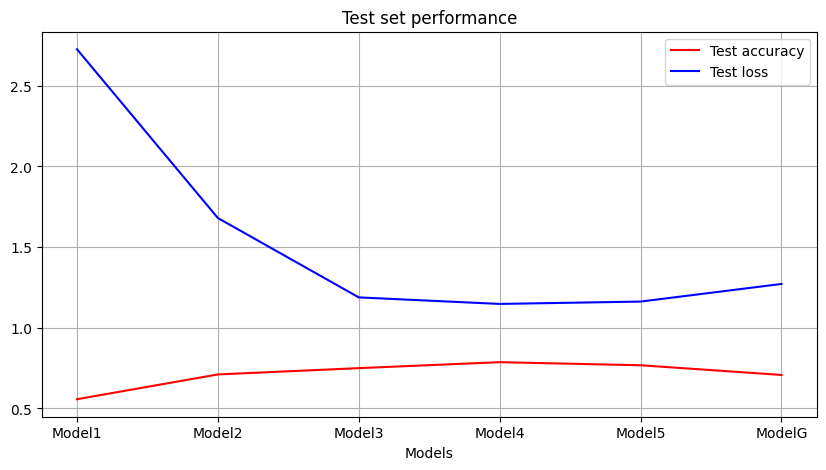

In [ ]:
plot_test(loss,accuracy)

### Confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
def plot_cm(model,x_test_,y_test_):
# 获取模型在测试集上的预测结果
  y_pred = model.predict(x_test_)

  # 将预测结果转换为类别标签
  y_pred_classes = np.argmax(y_pred, axis=1)
  y_true_classes = np.argmax(y_test_, axis=1)

  # 计算混淆矩阵
  conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

  # 计算分类报告
  class_report = classification_report(y_true_classes, y_pred_classes)

  # 打印分类报告
  print("Classification Report:")
  print(class_report)

  # 绘制混淆矩阵
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.xticks(ticks=np.arange(len(conf_matrix)), labels=LABELS)
  plt.yticks(ticks=np.arange(len(conf_matrix)), labels=LABELS)
  plt.show()




4/4 [==============================] - 2s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        34
           1       0.56      0.82      0.67        28
           2       0.46      0.59      0.52        29
           3       0.35      0.19      0.25        31

    accuracy                           0.56       122
   macro avg       0.55      0.56      0.54       122
weighted avg       0.55      0.56      0.54       122



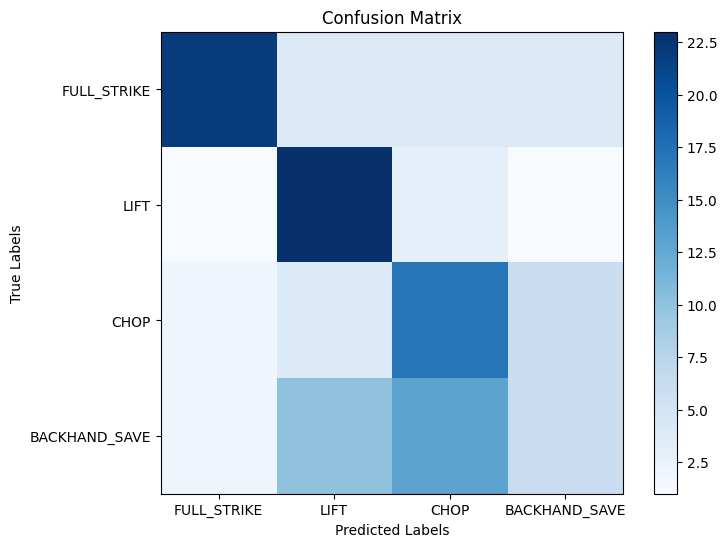

4/4 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.81        36
           1       0.81      0.87      0.84        39
           2       0.62      0.75      0.68        28
           3       0.42      0.44      0.43        25

    accuracy                           0.71       128
   macro avg       0.70      0.69      0.69       128
weighted avg       0.73      0.71      0.72       128



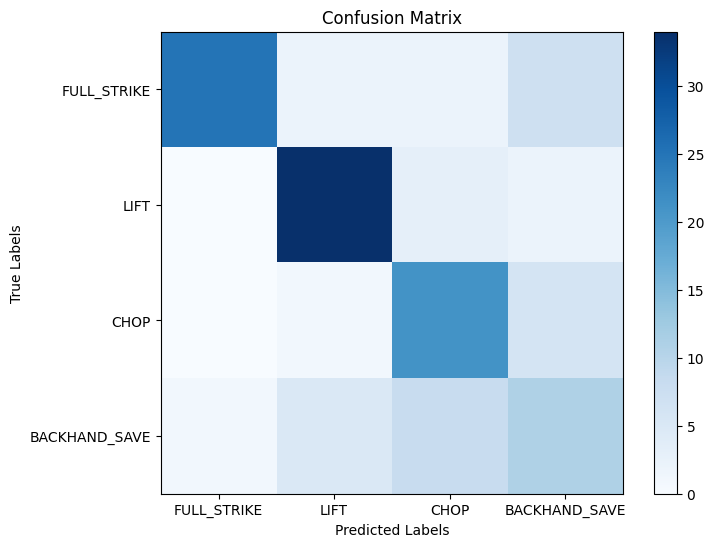

4/4 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        24
           1       0.87      0.77      0.81        43
           2       0.57      0.77      0.66        26
           3       0.82      0.61      0.70        23

    accuracy                           0.75       116
   macro avg       0.76      0.74      0.74       116
weighted avg       0.77      0.75      0.75       116



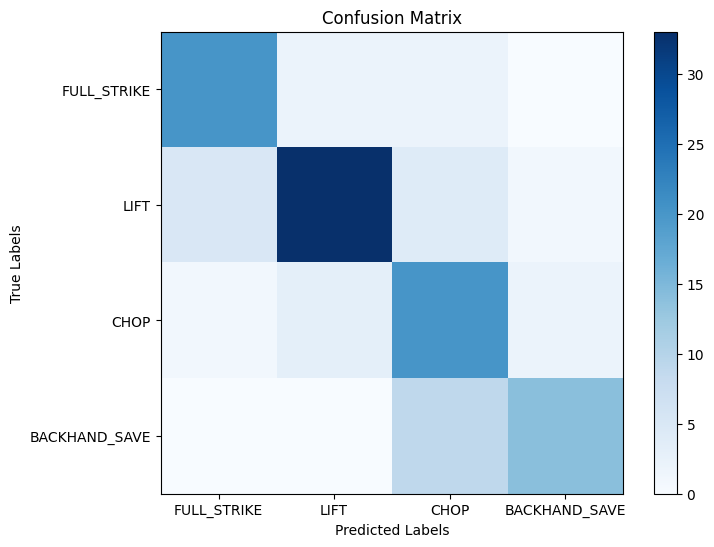

4/4 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.87      0.76      0.81        34
           2       0.70      0.90      0.79        29
           3       0.70      0.63      0.67        30

    accuracy                           0.79       122
   macro avg       0.79      0.79      0.79       122
weighted avg       0.79      0.79      0.79       122



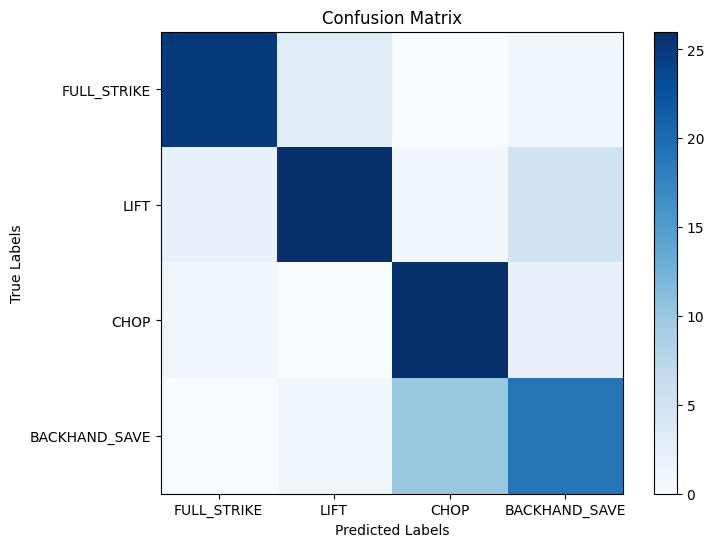

5/5 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.87      0.90        38
           1       0.87      0.87      0.87        30
           2       0.69      0.91      0.78        32
           3       0.82      0.62      0.71        29

    accuracy                           0.82       129
   macro avg       0.83      0.82      0.82       129
weighted avg       0.83      0.82      0.82       129



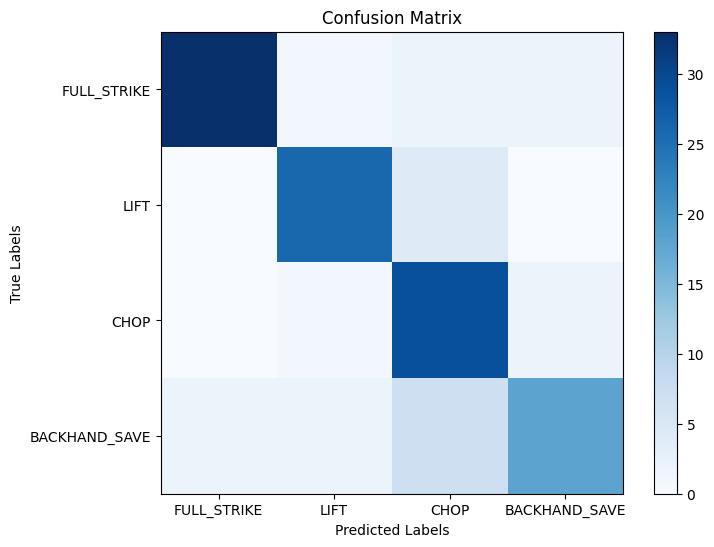

5/5 [==============================] - 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        46
           1       0.75      0.82      0.78        44
           2       0.79      0.75      0.77        36
           3       0.42      0.39      0.41        28

    accuracy                           0.71       154
   macro avg       0.68      0.68      0.68       154
weighted avg       0.70      0.71      0.71       154



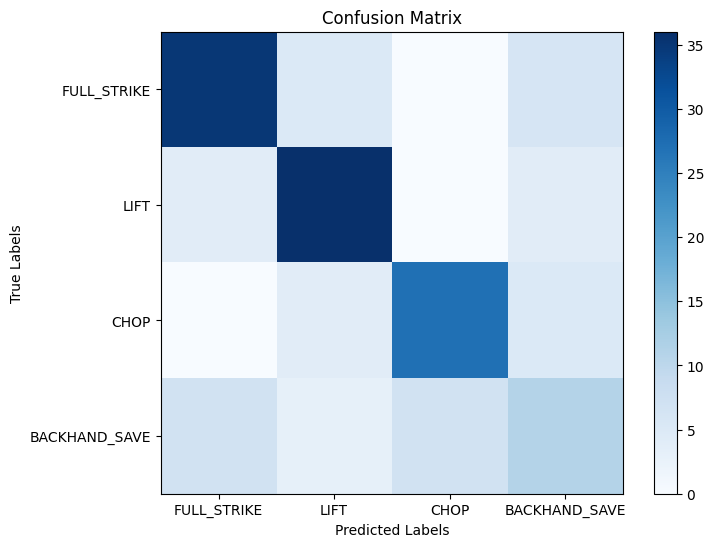

In [ ]:
plot_cm(model_1,x_test_1,y_test_1)
plot_cm(model_2,x_test_2,y_test_2)
plot_cm(model_3,x_test_3,y_test_3)
plot_cm(model_4,x_test_4,y_test_4)
plot_cm(model_5,x_test_5,y_test_5)
plot_cm(model_g,x_test_g,y_test_g)


# Quantized model

In [ ]:
MODELS_DIR = os.path.join(DATA_PATH,"Models")
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR,"IBED")
FLOAT_TFL_MODEL_FILENAME = MODELS_DIR
print(FLOAT_TFL_MODEL_FILENAME)
QUANTIZED_TFL_MODEL_FILENAME = MODELS_DIR
# TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "IBED.cc")
TFL_CC_MODEL_FILENAME = MODELS_DIR

/content/drive/MyDrive/EE488/Models


In [ ]:
model_1.save(SAVED_MODEL_FILENAME+"_1")
model_2.save(SAVED_MODEL_FILENAME+"_2")
model_3.save(SAVED_MODEL_FILENAME+"_3")
model_4.save(SAVED_MODEL_FILENAME+"_4")
model_5.save(SAVED_MODEL_FILENAME+"_5")
model_g.save(SAVED_MODEL_FILENAME+"_g")

## No quantized model

In [ ]:
converter1 = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter2 = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter3 = tf.lite.TFLiteConverter.from_keras_model(model_3)
converter4 = tf.lite.TFLiteConverter.from_keras_model(model_4)
converter5 = tf.lite.TFLiteConverter.from_keras_model(model_5)
converterg = tf.lite.TFLiteConverter.from_keras_model(model_g)

In [ ]:
def no_quantized(converter,model,name):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
  converter._experimental_lower_tensor_list_ops = False
  model_no_quant_tflite = converter.convert()
  PATH = os.path.join(FLOAT_TFL_MODEL_FILENAME,name)
  open(PATH, "wb").write(model_no_quant_tflite)


In [ ]:
no_quantized(converter1,model_1,"IBED_1.tfl")
no_quantized(converter2,model_2,"IBED_2.tfl")
no_quantized(converter3,model_3,"IBED_3.tfl")
no_quantized(converter4,model_4,"IBED_4.tfl")
no_quantized(converter5,model_5,"IBED_5.tfl")
no_quantized(converterg,model_g,"IBED_g.tfl")

## Quantized model

In [ ]:
def quantized(converter,model,name,datas):
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # Enforce integer only quantization
  converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
  converter.inference_input_type = tf.int8
  converter.inference_output_type = tf.int8
  def representative_dataset(datas):
    for test in datas:
      data = tf.expand_dims(test, 0)
      yield([data])
  # Provide a representative dataset to ensure we quantize correctly.
  converter.representative_dataset = lambda: representative_dataset(datas)
  model_tflite = converter.convert()
  # Save the model to dis
  PATH = os.path.join(QUANTIZED_TFL_MODEL_FILENAME,name)
  open(PATH, "wb").write(model_tflite)

In [ ]:
quantized(converter1,model_1,"IBED_q1.tfl",x_test_1.astype(np.float32))
quantized(converter2,model_2,"IBED_q2.tfl",x_test_2.astype(np.float32))
quantized(converter3,model_3,"IBED_q3.tfl",x_test_3.astype(np.float32))
quantized(converter4,model_4,"IBED_q4.tfl",x_test_4.astype(np.float32))
quantized(converter5,model_5,"IBED_q5.tfl",x_test_5.astype(np.float32))
quantized(converterg,model_g,"IBED_qg.tfl",x_test_g.astype(np.float32))

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.10/dist

##cc

In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME+"/IBED_q5.tfl"} > {TFL_CC_MODEL_FILENAME+'/IBED_q5.cc'}

## Model Definition(Pytorch)

In [ ]:
model = Sequential()
model.add(LSTM(120, return_sequences=True, input_shape=(1, 120)))
model.add(Dropout(0.4))
model.add(LSTM(120))
model.add(Dropout(0.4))
model.add(Dense(120, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 120)            115680    
                                                                 
 dropout_2 (Dropout)         (None, 1, 120)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               115680    
                                                                 
 dropout_3 (Dropout)         (None, 120)               0         
                                                                 
 dense_2 (Dense)             (None, 120)               14520     
                                                                 
 dense_3 (Dense)             (None, 4)                 484       
                                                                 
Total params: 246364 (962.36 KB)
Trainable params: 246

In [ ]:
print(x_train__.shape)

(614, 1, 120)


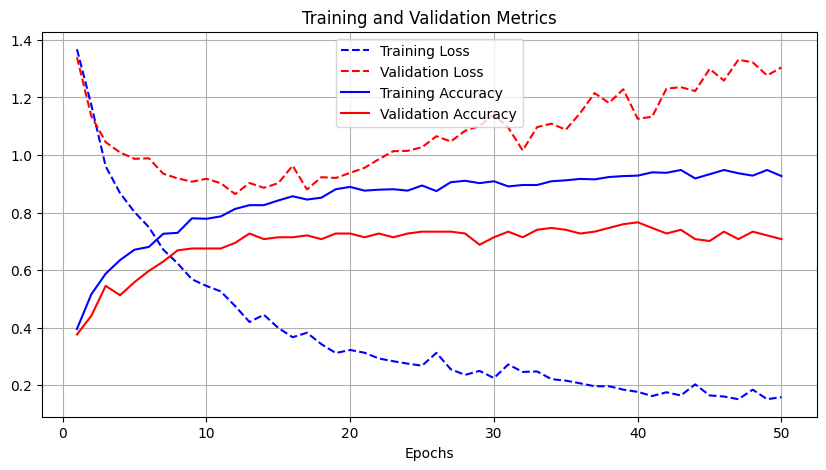

In [ ]:


# 提取训练和验证过程中的损失和准确率
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# 绘制图表
plt.figure(figsize=(10, 5))

# 绘制损失曲线
plt.plot(epochs, train_loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')

# 绘制准确率曲线
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend()
plt.show()


5/5 [==============================] - 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        36
           1       0.71      0.83      0.77        36
           2       0.66      0.84      0.74        44
           3       0.68      0.50      0.58        38

    accuracy                           0.71       154
   macro avg       0.72      0.70      0.70       154
weighted avg       0.72      0.71      0.70       154



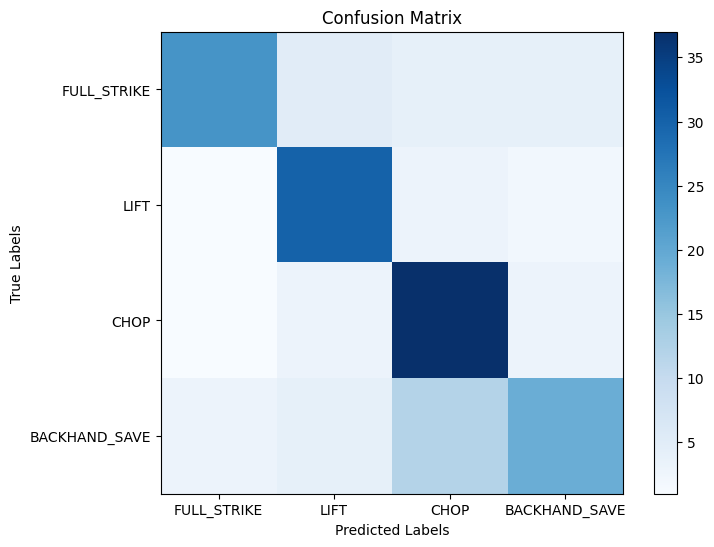

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# 获取模型在测试集上的预测结果
y_pred = model.predict(x_test__)

# 将预测结果转换为类别标签
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# 计算分类报告
class_report = classification_report(y_true_classes, y_pred_classes)

# 打印分类报告
print("Classification Report:")
print(class_report)

# 绘制混淆矩阵
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(ticks=np.arange(len(conf_matrix)), labels=LABELS)
plt.yticks(ticks=np.arange(len(conf_matrix)), labels=LABELS)
plt.show()
# LABELS = [
#     "FULL_STRIKE",
#     "CHOP",
#     "BACKHAND_SAVE",
#     "LIFT",
# ]



In [ ]:
MODELS_DIR = os.path.join(DATA_PATH, 'models')
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
SAVED_MODEL_FILENAME = os.path.join(MODELS_DIR, "MODEL")
#model_u1.save(SAVED_MODEL_FILENAME+"_u1")
FLOAT_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "MODEL_FLOAT.tfl")
QUANTIZED_TFL_MODEL_FILENAME = os.path.join(MODELS_DIR, "MODEL.tfl")
TFL_CC_MODEL_FILENAME = os.path.join(MODELS_DIR, "MODEL.cc")

model.save(SAVED_MODEL_FILENAME)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_FILENAME)
model_no_quant_tflite = converter.convert()
# Save the model to disk
open(FLOAT_TFL_MODEL_FILENAME, "wb").write(model_no_quant_tflite)

# def representative_dataset():
#   for filename in glob.glob(TEST_DIR + "/*/*.png"):
#     img = keras.preprocessing.image.load_img(filename, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
#     img_array = keras.preprocessing.image.img_to_array(img)
#     img_array = tf.expand_dims(img_array, 0)  # Create batch axis for images, labels in train_ds.take(1):
#     yield([img_array])

# # Set the optimization flag.
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# # Enforce integer only quantization
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
# # Provide a representative dataset to ensure we quantize correctly.
# converter.representative_dataset = representative_dataset
# model_tflite = converter.convert()

# # Save the model to disk
# open(QUANTIZED_TFL_MODEL_FILENAME, "wb").write(model_tflite)

ConverterError: <unknown>:0: error: loc(callsite(callsite(callsite(fused["TensorListReserve:", "TensorArrayV2_1@__inference_standard_lstm_197003"] at fused["PartitionedCall:", "model_4/lstm_12/PartitionedCall@__inference__wrapped_model_197717"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_201461"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.TensorListReserve' op requires element_shape to be static during TF Lite transformation pass
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: loc(callsite(callsite(callsite(fused["TensorListReserve:", "TensorArrayV2_1@__inference_standard_lstm_197003"] at fused["PartitionedCall:", "model_4/lstm_12/PartitionedCall@__inference__wrapped_model_197717"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_201461"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): failed to legalize operation 'tf.TensorListReserve' that was explicitly marked illegal
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: error: Lowering tensor list ops is failed. Please consider using Select TF ops and disabling `_experimental_lower_tensor_list_ops` flag in the TFLite converter object. For example, converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]\n converter._experimental_lower_tensor_list_ops = False


In [ ]:
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {QUANTIZED_TFL_MODEL_FILENAME} > {TFL_CC_MODEL_FILENAME}
# Update variable names
REPLACE_TEXT = QUANTIZED_TFL_MODEL_FILENAME.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_magic_wand_model_data/g' {TFL_CC_MODEL_FILENAME}